First we import packages for time series forecasting.

In [1]:
from datetime import datetime
from forex_python.converter import get_rate
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import ADF
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

We read the EUR vs USD currency data into a dataframe.

In [2]:
dt = pd.read_csv("EURUSD_1d_output_with_null_value.csv")
dt.head()

,Unnamed: 0,Date,Time,Open,High,Low,Close,Volume,volume_adi,volume_obv,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
0,0,1971.01.04,00:00,0.5369,0.5369,0.5369,0.5369,1,0.0,1,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,-49.990122,NaN,0.000000
1,1,1971.01.05,00:00,0.5366,0.5366,0.5366,0.5366,1,0.0,0,...,NaN,0.0,0.000000,-100.0,0.0,NaN,NaN,-0.055876,-0.055892,-0.055876
2,2,1971.01.06,00:00,0.5365,0.5365,0.5365,0.5365,1,0.0,-1,...,NaN,0.0,0.000000,-100.0,0.0,NaN,NaN,-0.018636,-0.018638,-0.074502
3,3,1971.01.07,00:00,0.5368,0.5368,0.5368,0.5368,1,0.0,0,...,NaN,75.0,25.000000,-25.0,0.0,NaN,NaN,0.055918,0.055902,-0.018625
4,4,1971.01.08,00:00,0.5371,0.5371,0.5371,0.5371,1,0.0,1,...,NaN,100.0,58.333333,-0.0,0.0,NaN,NaN,0.055887,0.055871,0.037251


Now we choose close time as our forecasting target.

In [3]:
close = dt.Close
close.index = pd.DatetimeIndex(dt.Date).to_period('D')
close.head()

Date
1971-01-04    0.5369
1971-01-05    0.5366
1971-01-06    0.5365
1971-01-07    0.5368
1971-01-08    0.5371
Freq: D, Name: Close, dtype: float64

We choose the data after 2017.

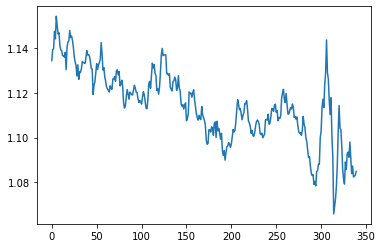

In [4]:
closeafter2019 = close['2019':]
plt.plot(closeafter2019.values)
plt.show()

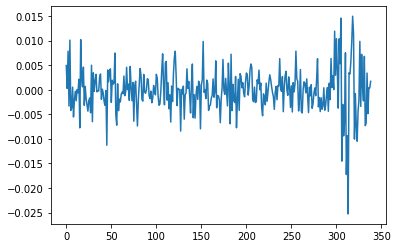

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
diff = difference(closeafter2019)
plt.plot(diff)
plt.show()

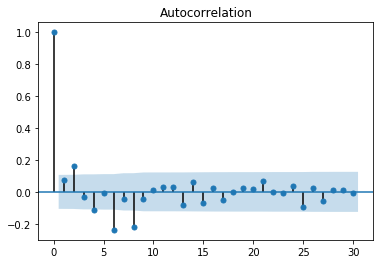

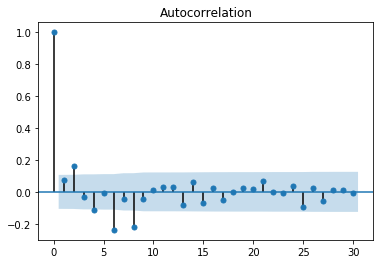

In [6]:
plot_acf(diff, use_vlines = True, lags = 30)

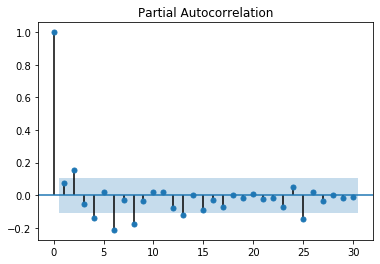

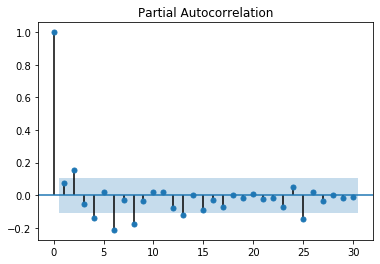

In [7]:
plot_pacf(diff, use_vlines = True, lags = 30)

In [8]:
steps = 15
EURUSDRetTrainDiff, EURUSDRetTestDiff = closeafter2019[0:-steps], closeafter2019[-steps:]
print(ADF(EURUSDRetTrainDiff, max_lags = 10).summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.853
P-value                         0.354
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [9]:
model1 = ARIMA(EURUSDRetTrainDiff, order = (1,1,1)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  324
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1302.692
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 31 May 2020   AIC                          -2597.383
Time:                        17:10:49   BIC                          -2582.260
Sample:                    01-03-2019   HQIC                         -2591.347
                         - 04-02-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.530      0.596      -0.001       0.000
ar.L1.D.Close     0.4685      0.181      2.595      0.009       0.115       0.822
ma.L1.D.Close    -0.3560      0.185     -1.926      0.054      -0.718       0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1344           +0.0000j            2.1344            0.0000
MA.1            2.8093           +0.0000j            2.8093            0.0000
-----------------------------------------------------------------------------
"""

In [10]:
model2 = ARIMA(EURUSDRetTrainDiff, order = (1,1,2)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  324
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1307.050
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 31 May 2020   AIC                          -2604.100
Time:                        17:10:49   BIC                          -2585.197
Sample:                    01-03-2019   HQIC                         -2596.555
                         - 04-02-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.527      0.598      -0.001       0.000
ar.L1.D.Close    -0.1583      0.237     -0.667      0.505      -0.624       0.307
ma.L1.D.Close     0.2481      0.232      1.070      0.285      -0.206       0.703
ma.L2.D.Close     0.2139      0.059      3.655      0.000       0.099       0.329
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.3154           +0.0000j            6.3154            0.5000
MA.1           -0.5799           -2.0827j            2.1620           -0.2932
MA.2           -0.5799           +2.0827j            2.1620            0.2932
-----------------------------------------------------------------------------
"""

In [11]:
model3 = ARIMA(EURUSDRetTrainDiff, order = (1,1,3)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  324
Model:                 ARIMA(1, 1, 3)   Log Likelihood                1318.063
Method:                       css-mle   S.D. of innovations              0.004
Date:                Sun, 31 May 2020   AIC                          -2624.126
Time:                        17:10:50   BIC                          -2601.441
Sample:                    01-03-2019   HQIC                         -2615.072
                         - 04-02-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0001   1.99e-05     -6.550      0.000      -0.000   -9.12e-05
ar.L1.D.Close     0.8333      0.038     22.146      0.000       0.760       0.907
ma.L1.D.Close    -0.8313      0.062    -13.348      0.000      -0.953      -0.709
ma.L2.D.Close     0.0919      0.072      1.285      0.199      -0.048       0.232
ma.L3.D.Close    -0.2605      0.057     -4.560      0.000      -0.373      -0.149
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2000           +0.0000j            1.2000            0.0000
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.3236           -1.9321j            1.9591           -0.2764
MA.3           -0.3236           +1.9321j            1.9591            0.2764
-----------------------------------------------------------------------------
"""

Here we choose the model with the smallest AIC, which is ARIMA(1,1,3)

In [12]:
model = ARIMA(EURUSDRetTrainDiff, order = (1,1,3))
model_fit = model.fit()
output = model_fit.forecast(steps=steps)
error = mean_squared_error(EURUSDRetTestDiff.values, output[0])
print('Test MSE: %f' % error)

Test MSE: 0.000033


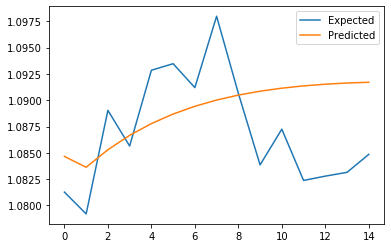

In [13]:
plt.plot(EURUSDRetTestDiff.values, label = 'Expected')
plt.plot(output[0], label = 'Predicted')
plt.legend()
plt.show()